# Machine learning Project By:
Ahmed Zaki : 2021005018
Seifeldin hassan : 2021005019
Mohamed dawoud : 2021004950
Tia Othman : 2021004913
Henad frnssis: 2021004908

# Preprocessing Method 1 (Averaging)

In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(5)
# Load the dataset
file_path = r"C:\Users\Admin\Downloads\Candidates\all_candidates_raw.csv"
df = pd.read_csv('/content/all_candidates_raw.csv')

# Drop unnecessary columns
df.drop(columns=['Comments', 'X1', 'X2', 'X3', 'Trigger', 'Time_Offset', 'ADC_Status', 'ADC_Sequence', 'Event'], inplace=True)

# Ensure 'Time' column is numeric
df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
df['Time'] = df['Time'].round().astype(int)

# --- Step 1: Average data per second ---
# Group by candidate, type, and Time, and calculate the mean of other columns
averaged_df = df.groupby(['candidate', 'type', 'Time']).mean()
averaged_df.reset_index(inplace=True)

# --- Step 2: Determine the maximum number of records per candidate-video combination ---
max_records_per_group = 60

processed_df = pd.DataFrame()

# --- Step 3: For each candidate-video pair, reaverage to match the max number of records ---
for (candidate, video_type), group in averaged_df.groupby(['candidate', 'type']):
    group_size = len(group)

    # First, if group size is less than the max, reaverage the data
    if group_size < max_records_per_group:
        # Averaging by 'Time' (already done per second)
        averaged_group = group.groupby(['candidate', 'type', 'Time']).mean().reset_index()

        # After averaging, if group size is still less than the max, we need to reaverage
        if len(averaged_group) < max_records_per_group:
            # Calculate new time range for resampling
            time_range = np.linspace(averaged_group['Time'].min(), averaged_group['Time'].max(), max_records_per_group)
            averaged_group.set_index('Time', inplace=True)
            averaged_group = averaged_group.reindex(time_range).interpolate().reset_index()

        # Ensure the candidate and video type labels are preserved
        averaged_group['candidate'] = candidate
        averaged_group['type'] = video_type

    else:
        # If the group already has the max number of records, just downsample to the max size
        averaged_group = group.sample(n=max_records_per_group, random_state=5)

    # Append the processed data
    processed_df = pd.concat([processed_df, averaged_group])

# Reset the index and show the processed data
processed_df.reset_index(drop=True, inplace=True)

# Output the processed dataset
print("Dataset 1: Processed Data")
print(processed_df.head(5))
print(f"Averaged data shape: {processed_df.shape}")


# --- Reshaping the first dataset
grouped_df = processed_df.groupby(['candidate', 'type'])
reshaped_data = []

for (candidate, video_type), group in grouped_df:
    if group.shape[0] == 60:
        flattened_data = []
        sensor_columns = [col for col in group.columns if col not in ['Time', 'candidate', 'type']]
        for sensor in sensor_columns:
            sensor_readings = group[sensor].values
            flattened_data.extend(sensor_readings)
        reshaped_columns = [f"{sensor}_{i+1}" for sensor in sensor_columns for i in range(60)]
        reshaped_group_df = pd.DataFrame([flattened_data], columns=reshaped_columns)
        reshaped_group_df['candidate'] = candidate
        reshaped_group_df['type'] = video_type
        reshaped_data.append(reshaped_group_df)

final_df = pd.concat(reshaped_data, axis=0)
final_df = final_df[['candidate', 'type'] + [col for col in final_df.columns if col not in ['candidate', 'type']]]
final_df.reset_index(drop=True, inplace=True)
print("Dataset 1: Reshaped Data")
print(final_df.head(5))
print(f"reshaped data shape: {final_df.shape}")

def augment_candidates_with_noise(data, num_new_candidates=15, noise_level=0.1):
    augmented_rows = []
    num_existing_candidates = len(data) // 3  # Assuming 3 types (adjust if needed)
    types = data['type'].unique()  # Get unique types

    for new_candidate_id in range(num_existing_candidates + 1, num_existing_candidates + num_new_candidates + 1):
        for t in types:
            # Select a random sample from the same type
            candidate_data = data[data['type'] == t].sample(n=1, random_state=np.random.randint(100)).iloc[0].copy()

            # Add Gaussian noise to numeric features (assuming EEG signals are numeric)
            for col in data.select_dtypes(include=[np.number]).columns:
                if col not in ['candidate', 'type']:  # Exclude 'candidate' and 'type'
                    std_dev = data[col].std()  # Standard deviation of the column
                    noise = np.random.normal(0, noise_level * std_dev, size=1)[0]
                    candidate_data[col] += noise

            # Assign a new candidate ID
            candidate_data['candidate'] = new_candidate_id
            augmented_rows.append(candidate_data)

    # Return augmented data as a DataFrame
    return pd.DataFrame(augmented_rows)


# Apply the augmented function
augmented_data = augment_candidates_with_noise(final_df, num_new_candidates=15, noise_level=0.1)

# Combine the augmented data with the original data
final_augmented_data = pd.concat([final_df, augmented_data], axis=0).reset_index(drop=True)

# Display the augmented data
print("Dataset 1: Augmented Data with Noise")
print(final_augmented_data.head(5))
print(f"Augmented data shape: {final_augmented_data.shape}")


# --- PCA Dataset 1
features = final_augmented_data.drop(columns=["candidate", "type"])
target = final_augmented_data["type"]
candidates = final_augmented_data["candidate"]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA()
pca.fit(features_scaled)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
optimal_components = np.argmax(explained_variance_ratio >= 0.95) + 1

pca_optimal = PCA(n_components=optimal_components)
features_pca_optimal = pca_optimal.fit_transform(features_scaled)

columns = [f"PCA{i+1}" for i in range(optimal_components)]
reduced_data_pca = pd.DataFrame(features_pca_optimal, columns=columns)
reduced_data_pca["candidate"] = candidates
reduced_data_pca["type"] = target
reduced_data_pca = reduced_data_pca[["candidate"] + columns + ["type"]]
print("Dataset 1: PCA Reduced Data")
print(reduced_data_pca.head(5))
print(f"reduced data shape: {reduced_data_pca.shape}")

<ipython-input-4-1c818007e9b6>:42: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  averaged_group = averaged_group.reindex(time_range).interpolate().reset_index()
<ipython-input-4-1c818007e9b6>:42: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  averaged_group = averaged_group.reindex(time_range).interpolate().reset_index()
<ipython-input-4-1c818007e9b6>:42: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  averaged_group = averaged_group.reindex(time_range).interpolate().reset_index()
<ipython-input-4-1c818007e9b6>:42: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version.

Dataset 1: Processed Data
       Time  candidate    type           P3          C3          F3  \
0  0.000000          1  comedy  2173.102000  207.474000 -530.032000   
1  0.169492          1  comedy  2112.668720  172.060779 -460.341389   
2  0.338983          1  comedy  2052.235439  136.647559 -390.650778   
3  0.508475          1  comedy  1991.802159  101.234338 -320.960167   
4  0.677966          1  comedy  1931.368879   65.821117 -251.269556   

           Fz          F4         C4          P4  ...          Fp2  \
0 -446.660000 -346.790000  69.922000   42.856000  ...   921.162000   
1 -531.405058 -298.053664  56.535991   63.250981  ...   989.455127   
2 -616.150115 -249.317327  43.149983   83.645962  ...  1057.748255   
3 -700.895173 -200.580991  29.763974  104.040942  ...  1126.041382   
4 -785.640230 -151.844654  16.377966  124.435923  ...  1194.334510   

           T3          T5         O1          O2           F7           F8  \
0 -876.938000  -95.894000  50.164000 -334.256000

# Preprocessing method 2 (Simple Random sampling)

In [6]:
# --- Second Dataset with Simple Random Sampling ---
df2 = pd.read_csv('/content/all_candidates_raw.csv')

# Drop unnecessary columns
df2.drop(columns=['Comments', 'X1', 'X2', 'X3', 'Trigger', 'Time_Offset', 'ADC_Status', 'ADC_Sequence', 'Event'], inplace=True)

grouped_df_2 = df2.groupby(['candidate', 'type', 'Time']).mean().reset_index()

# Function for simple random sampling
def simple_random_sampling(data, num_samples, replace=False):
    sampled_indices = np.random.choice(data.shape[0], size=num_samples, replace=replace)
    sampled_data = data.iloc[sampled_indices, :]
    return sampled_data

# Define the number of records per group
records_per_group_2 = 60

processed_data_2 = pd.DataFrame()

# Perform the processing
for (candidate_2, video_type_2), group_2 in grouped_df_2.groupby(['candidate', 'type']):
    group_size_2 = len(group_2)

    if group_size_2 > records_per_group_2:
        sampled_group_2 = simple_random_sampling(group_2, records_per_group_2, replace=False)
    else:
        sampled_group_2 = simple_random_sampling(group_2, records_per_group_2, replace=True)

    processed_data_2 = pd.concat([processed_data_2, sampled_group_2])

processed_data_2.reset_index(drop=True, inplace=True)

# --- Reshaping the second dataset ---
reshaped_data_2 = []

for (candidate_2, video_type_2), group_2 in processed_data_2.groupby(['candidate', 'type']):
    if group_2.shape[0] == records_per_group_2:
        flattened_data_2 = []
        sensor_columns_2 = [col for col in group_2.columns if col not in ['Time', 'candidate', 'type']]
        for sensor_2 in sensor_columns_2:
            sensor_readings_2 = group_2[sensor_2].values
            flattened_data_2.extend(sensor_readings_2)
        reshaped_columns_2 = [f"{sensor_2}_{i+1}" for sensor_2 in sensor_columns_2 for i in range(records_per_group_2)]
        reshaped_group_df_2 = pd.DataFrame([flattened_data_2], columns=reshaped_columns_2)
        reshaped_group_df_2['candidate'] = candidate_2
        reshaped_group_df_2['type'] = video_type_2
        reshaped_data_2.append(reshaped_group_df_2)

final_reshaped_data_2 = pd.concat(reshaped_data_2, axis=0)
final_reshaped_data_2 = final_reshaped_data_2[['candidate', 'type'] + [col for col in final_reshaped_data_2.columns if col not in ['candidate', 'type']]]
final_reshaped_data_2.reset_index(drop=True, inplace=True)


# --- Augmentation of Dataset 2 ---
augmented_data_2 = augment_candidates_with_noise(final_reshaped_data_2, num_new_candidates=15, noise_level=0.1)
final_augmented_data_2 = pd.concat([final_reshaped_data_2, augmented_data_2], axis=0).reset_index(drop=True)
print("Dataset 2: Augmented Data")
print(final_augmented_data_2.head(5))
print(f"Augmented data shape: {final_augmented_data_2.shape}")


# --- PCA Dataset 2 ---
features_2 = final_augmented_data_2.drop(columns=["candidate", "type"])
target_2 = final_augmented_data_2["type"]
candidates_2 = final_augmented_data_2["candidate"]

features_scaled_2 = scaler.fit_transform(features_2)

pca_2 = PCA()
pca_2.fit(features_scaled_2)
explained_variance_ratio_2 = np.cumsum(pca_2.explained_variance_ratio_)
optimal_components_2 = np.argmax(explained_variance_ratio_2 >= 0.95) + 1

pca_optimal_2 = PCA(n_components=optimal_components_2)
features_pca_optimal_2 = pca_optimal_2.fit_transform(features_scaled_2)

pca_columns_2 = [f"PCA{i+1}" for i in range(optimal_components_2)]
reduced_data_pca_2 = pd.DataFrame(features_pca_optimal_2, columns=pca_columns_2)
reduced_data_pca_2["candidate"] = candidates_2
reduced_data_pca_2["type"] = target_2
reduced_data_pca_2 = reduced_data_pca_2[["candidate"] + pca_columns_2 + ["type"]]
print("Dataset 2: PCA Reduced Data")
print(reduced_data_pca_2.head(5))
print(f"Reduced data shape: {reduced_data_pca_2.shape}")


Dataset 2: Augmented Data
   candidate     type    P3_1    P3_2    P3_3    P3_4    P3_5    P3_6    P3_7  \
0          1   comedy  2248.2  2189.1 -1586.4  2290.8  2183.7 -1327.2  2143.5   
1          1  neutral   933.0   676.5   708.9   670.2   865.2   946.2   707.7   
2          1      sad   330.3   650.1   235.2   552.9   306.6   234.0   477.9   
3          2   comedy  -957.0 -1181.1  1873.2  -695.1  -979.8 -1059.9  -627.3   
4          2  neutral  -893.1  -306.9   197.4  -302.1  -226.5  -396.9  -275.1   

     P3_8  ...   T4_51   T4_52   T4_53   T4_54   T4_55   T4_56   T4_57  \
0  2218.2  ... -2738.7 -1523.7 -1899.9  -916.2 -1782.6 -1032.6  -893.7   
1   692.7  ... -1595.1 -1471.8 -1482.0 -1476.0 -1468.8 -1545.3 -1477.8   
2   554.1  ... -1837.8 -1989.9 -1968.6 -1956.9 -2284.2 -1633.2 -2063.4   
3 -1094.7  ...  -225.0  -795.9   285.6   226.5   297.0    55.5   179.7   
4  -339.6  ...  1074.0   612.0   521.7  1573.5   494.4  1730.1  1102.8   

    T4_58   T4_59   T4_60  
0 -1671.9 -510

# Visualization

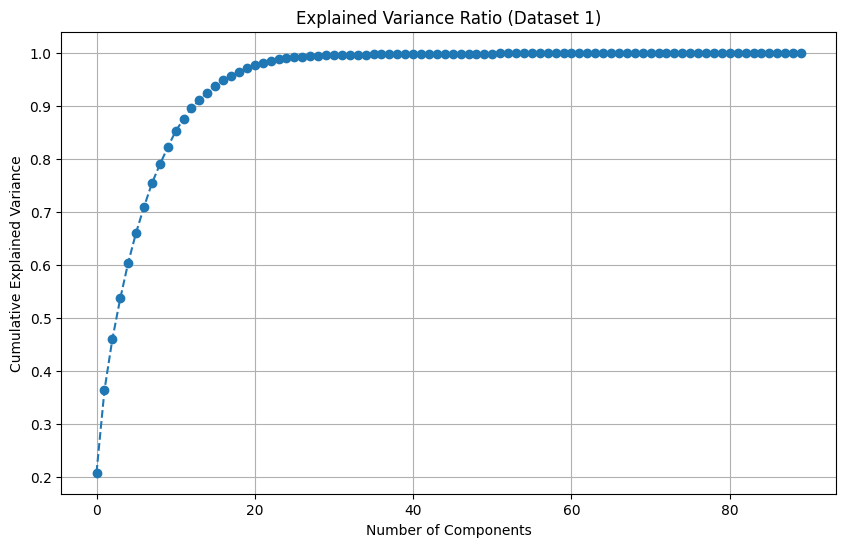

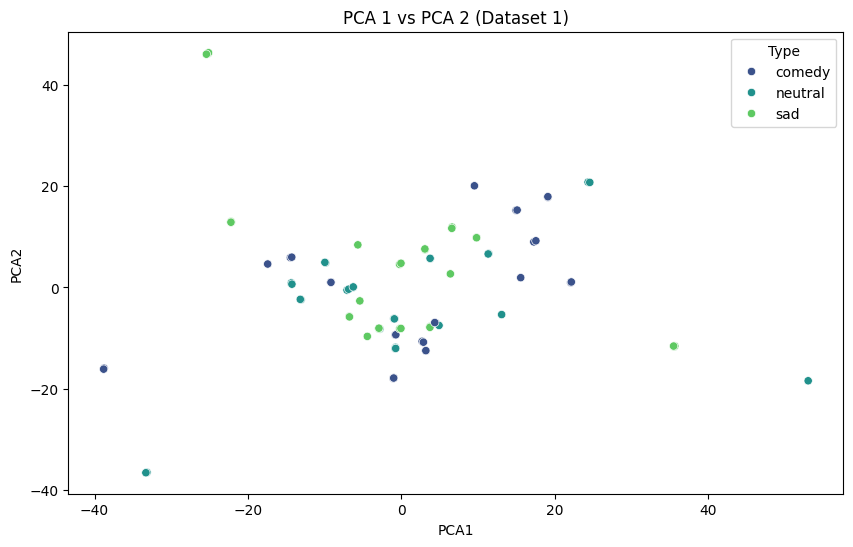

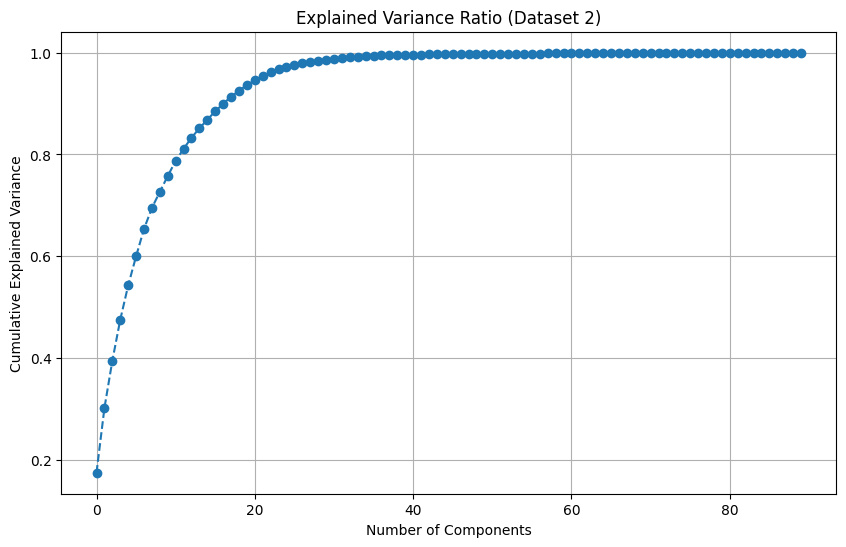

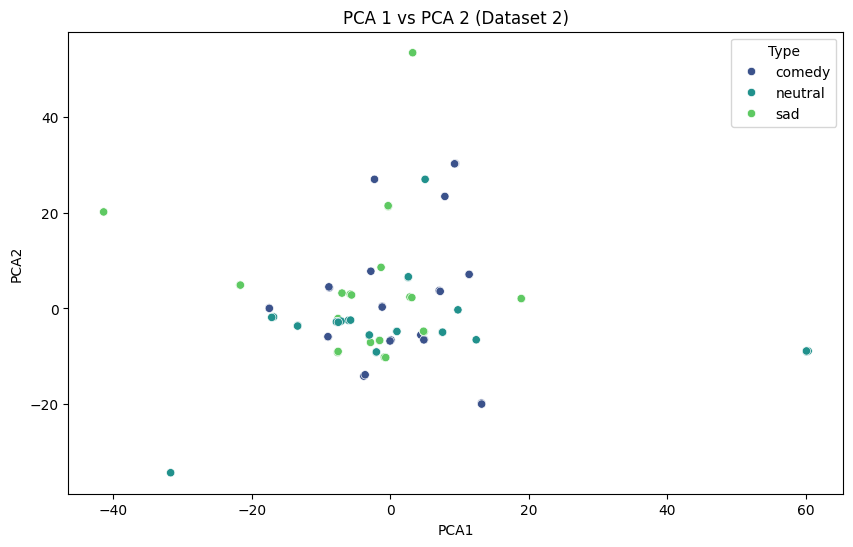

In [7]:
# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the explained variance for PCA (Dataset 1)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance Ratio (Dataset 1)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Visualizing the PCA components (Dataset 1)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data_pca['PCA1'], y=reduced_data_pca['PCA2'], hue=reduced_data_pca['type'], palette='viridis')
plt.title('PCA 1 vs PCA 2 (Dataset 1)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Type')
plt.show()

# Visualizing the explained variance for PCA (Dataset 2)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance Ratio (Dataset 2)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Visualizing the PCA components (Dataset 2)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data_pca_2['PCA1'], y=reduced_data_pca_2['PCA2'], hue=reduced_data_pca_2['type'], palette='viridis')
plt.title('PCA 1 vs PCA 2 (Dataset 2)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Type')
plt.show()

# Neural networks

In [8]:
# --- Neural Networks ---

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare the features and target from final_df (Dataset 1)
X_1 = final_df.drop(columns=["candidate", "type"])
y_1 = final_df["type"]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=5)

# Create a neural network classifier
nn_classifier_1 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=5)

nn_classifier_1.fit(X_train_1, y_train_1)

y_pred_1 = nn_classifier_1.predict(X_test_1)

# Evaluate the model
print("Dataset using method 1: Neural Network Performance")
print("Accuracy:", accuracy_score(y_test_1, y_pred_1))
print(classification_report(y_test_1, y_pred_1))

X_2 = final_reshaped_data_2.drop(columns=["candidate", "type"])
y_2 = final_reshaped_data_2["type"]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=5)

# Create a neural network classifier
nn_classifier_2 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=5)

nn_classifier_2.fit(X_train_2, y_train_2)

y_pred_2 = nn_classifier_2.predict(X_test_2)

# Evaluate the model
print("Dataset using Methord 2: Neural Network Performance")
print("Accuracy:", accuracy_score(y_test_2, y_pred_2))
print(classification_report(y_test_2, y_pred_2))

X_3 = final_augmented_data.drop(columns=["candidate", "type"])
y_3 = final_augmented_data["type"]

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=5)

# Create a neural network classifier
nn_classifier_3 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=5)

nn_classifier_3.fit(X_train_3, y_train_3)

y_pred_3 = nn_classifier_3.predict(X_test_3)

# Evaluate the model
print("Augmentation of Dataset using method 1: Neural Network Performance")
print("Accuracy:", accuracy_score(y_test_3, y_pred_3))
print(classification_report(y_test_3, y_pred_3))

Dataset using method 1: Neural Network Performance
Accuracy: 0.4444444444444444
              precision    recall  f1-score   support

      comedy       0.67      0.50      0.57         4
     neutral       1.00      0.25      0.40         4
         sad       0.20      1.00      0.33         1

    accuracy                           0.44         9
   macro avg       0.62      0.58      0.43         9
weighted avg       0.76      0.44      0.47         9

Dataset using Methord 2: Neural Network Performance
Accuracy: 0.2222222222222222
              precision    recall  f1-score   support

      comedy       0.00      0.00      0.00         4
     neutral       0.50      0.25      0.33         4
         sad       0.17      1.00      0.29         1

    accuracy                           0.22         9
   macro avg       0.22      0.42      0.21         9
weighted avg       0.24      0.22      0.18         9

Augmentation of Dataset using method 1: Neural Network Performance
Accuracy: 

From this point onwards DataSet 1 is referring to the None dimensionally reduced augmented dataset and DataSet 2 is the dimensionally reduced augmented dataset for only the averaging method. (just to avoid confusion) because the better model was picked to proceed with model comparison

# Random Forest

In [9]:
# --- Random Forest with GridSearchCV ---
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

print("\nRandom Forest Performance with GridSearchCV")

# --- Random Forest for Dataset 1 (using final_augmented_data) ---
# Prepare the features and target for Random Forest (Dataset 1)
X_rf_1 = final_augmented_data.drop(columns=["candidate", "type"])
y_rf_1 = final_augmented_data["type"]

# Split the data
X_train_rf_1, X_test_rf_1, y_train_rf_1, y_test_rf_1 = train_test_split(
    X_rf_1, y_rf_1, test_size=0.2, random_state=5, stratify=y_rf_1
)

# Define the parameter grid
param_grid_rf_1 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the model
rf_1 = RandomForestClassifier(random_state=5)

# Perform GridSearchCV
grid_search_rf_1 = GridSearchCV(
    estimator=rf_1,
    param_grid=param_grid_rf_1,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search_rf_1.fit(X_train_rf_1, y_train_rf_1)

# Best parameters and model
best_model_rf_1 = grid_search_rf_1.best_estimator_

# Predict on test set
y_pred_rf_1 = best_model_rf_1.predict(X_test_rf_1)

# Evaluate the model for Dataset 1
print("\nDataset 1: Random Forest Performance")
print("Accuracy:", accuracy_score(y_test_rf_1, y_pred_rf_1))
print("\nClassification Report:")
print(classification_report(y_test_rf_1, y_pred_rf_1))
print("\nBest Parameters:", grid_search_rf_1.best_params_)

# --- Random Forest for Dataset 2 (using reduced_data_pca) ---
# Prepare the features and target for Random Forest (Dataset 2)
X_rf_2 = reduced_data_pca.drop(columns=["candidate", "type"])
y_rf_2 = reduced_data_pca["type"]

# Split the data
X_train_rf_2, X_test_rf_2, y_train_rf_2, y_test_rf_2 = train_test_split(
    X_rf_2, y_rf_2, test_size=0.2, random_state=5, stratify=y_rf_2
)

# Define the parameter grid (same as Dataset 1)
param_grid_rf_2 = param_grid_rf_1

# Initialize the model
rf_2 = RandomForestClassifier(random_state=5)

# Perform GridSearchCV
grid_search_rf_2 = GridSearchCV(
    estimator=rf_2,
    param_grid=param_grid_rf_2,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search_rf_2.fit(X_train_rf_2, y_train_rf_2)

# Best parameters and model
best_model_rf_2 = grid_search_rf_2.best_estimator_

# Predict on test set
y_pred_rf_2 = best_model_rf_2.predict(X_test_rf_2)

# Evaluate the model for Dataset 2
print("\nDataset 2: Random Forest Performance")
print("Accuracy:", accuracy_score(y_test_rf_2, y_pred_rf_2))
print("\nClassification Report:")
print(classification_report(y_test_rf_2, y_pred_rf_2))
print("\nBest Parameters:", grid_search_rf_2.best_params_)



Random Forest Performance with GridSearchCV
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Dataset 1: Random Forest Performance
Accuracy: 0.7222222222222222

Classification Report:
              precision    recall  f1-score   support

      comedy       0.67      1.00      0.80         6
     neutral       0.80      0.67      0.73         6
         sad       0.75      0.50      0.60         6

    accuracy                           0.72        18
   macro avg       0.74      0.72      0.71        18
weighted avg       0.74      0.72      0.71        18


Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Dataset 2: Random Forest Performance
Accuracy: 0.7777777777777778

Classification Report:
              precision    recall  f1-score   support

      comedy       0.67      1.00      0.80         6
     neutral       1.00      0.6

# SVM

In [10]:
# --- Support Vector Machine (SVM) Implementation ---
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# --- SVM for Dataset 1 (using final_augmented_data) ---
# Prepare the features and target for SVM (Dataset 1)
X_svm_1 = final_augmented_data.drop(columns=["candidate", "type"])
y_svm_1 = final_augmented_data["type"]

X_train_svm_1, X_test_svm_1, y_train_svm_1, y_test_svm_1 = train_test_split(
    X_svm_1, y_svm_1, test_size=0.2, random_state=5, stratify=y_svm_1
)

# Standardize the features
scaler_svm_1 = StandardScaler()
X_train_svm_1_scaled = scaler_svm_1.fit_transform(X_train_svm_1)
X_test_svm_1_scaled = scaler_svm_1.transform(X_test_svm_1)

# Initialize and train the SVM model
svm_model_1 = SVC(kernel='linear', random_state=5)
svm_model_1.fit(X_train_svm_1_scaled, y_train_svm_1)

# Make predictions
y_pred_svm_1 = svm_model_1.predict(X_test_svm_1_scaled)

# Evaluate the model
print("\nDataset 1: SVM Performance")
print("Accuracy:", accuracy_score(y_test_svm_1, y_pred_svm_1))
print("\nClassification Report:")
print(classification_report(y_test_svm_1, y_pred_svm_1))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_svm_1, y_pred_svm_1))

# --- SVM for Dataset 2 (using reduced_data_pca) ---
# Prepare the features and target for SVM (Dataset 2)
X_svm_2 = reduced_data_pca.drop(columns=["candidate", "type"])
y_svm_2 = reduced_data_pca["type"]

X_train_svm_2, X_test_svm_2, y_train_svm_2, y_test_svm_2 = train_test_split(
    X_svm_2, y_svm_2, test_size=0.2, random_state=5, stratify=y_svm_2
)

# Standardize the features
scaler_svm_2 = StandardScaler()
X_train_svm_2_scaled = scaler_svm_2.fit_transform(X_train_svm_2)
X_test_svm_2_scaled = scaler_svm_2.transform(X_test_svm_2)

# Initialize and train the SVM model
svm_model_2 = SVC(kernel='linear', random_state=5)
svm_model_2.fit(X_train_svm_2_scaled, y_train_svm_2)

# Make predictions
y_pred_svm_2 = svm_model_2.predict(X_test_svm_2_scaled)

# Evaluate the model
print("\nDataset 2: SVM Performance")
print("Accuracy:", accuracy_score(y_test_svm_2, y_pred_svm_2))
print("\nClassification Report:")
print(classification_report(y_test_svm_2, y_pred_svm_2))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_svm_2, y_pred_svm_2))


Dataset 1: SVM Performance
Accuracy: 0.7222222222222222

Classification Report:
              precision    recall  f1-score   support

      comedy       0.67      1.00      0.80         6
     neutral       0.80      0.67      0.73         6
         sad       0.75      0.50      0.60         6

    accuracy                           0.72        18
   macro avg       0.74      0.72      0.71        18
weighted avg       0.74      0.72      0.71        18


Confusion Matrix:
[[6 0 0]
 [1 4 1]
 [2 1 3]]

Dataset 2: SVM Performance
Accuracy: 0.6666666666666666

Classification Report:
              precision    recall  f1-score   support

      comedy       0.67      1.00      0.80         6
     neutral       0.67      0.67      0.67         6
         sad       0.67      0.33      0.44         6

    accuracy                           0.67        18
   macro avg       0.67      0.67      0.64        18
weighted avg       0.67      0.67      0.64        18


Confusion Matrix:
[[6 0 0]
 

# Gradient Boosting

In [11]:
# --- Gradient Boosting Implementation ---
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from imblearn.over_sampling import SMOTE

# --- Gradient Boosting for Dataset 1 (using final_augmented_data) ---
print("\nGradient Boosting using SMOTE")
# Prepare the features and target for Gradient Boosting (Dataset 1)
X_gb_1 = final_augmented_data.drop(columns=["candidate", "type"])
y_gb_1 = final_augmented_data["type"]

# Split the data
X_train_gb_1, X_test_gb_1, y_train_gb_1, y_test_gb_1 = train_test_split(
    X_gb_1, y_gb_1, test_size=0.2, random_state=5, stratify=y_gb_1
)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=5)
X_train_gb_1_balanced, y_train_gb_1_balanced = smote.fit_resample(X_train_gb_1, y_train_gb_1)

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 7),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Initialize the Gradient Boosting model
gb_model_1 = GradientBoostingClassifier(random_state=5)

# Initialize RandomizedSearchCV
random_search_1 = RandomizedSearchCV(
    estimator=gb_model_1,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=2,
    n_jobs=-1,
    verbose=1,
    random_state=5
)

# Fit the model
random_search_1.fit(X_train_gb_1_balanced, y_train_gb_1_balanced)

# Get the best model
best_model_gb_1 = random_search_1.best_estimator_

# Make predictions
y_pred_gb_1 = best_model_gb_1.predict(X_test_gb_1)

# Evaluate the model
print("\nDataset 1: Gradient Boosting Performance")
print("Accuracy:", accuracy_score(y_test_gb_1, y_pred_gb_1))
print("Best Parameters:", random_search_1.best_params_)
print("\nClassification Report:")
print(classification_report(y_test_gb_1, y_pred_gb_1))

# --- Gradient Boosting for Dataset 2 (using reduced_data_pca) ---
# Prepare the features and target for Gradient Boosting (Dataset 2)
X_gb_2 = reduced_data_pca.drop(columns=["candidate", "type"])
y_gb_2 = reduced_data_pca["type"]

# Split the data
X_train_gb_2, X_test_gb_2, y_train_gb_2, y_test_gb_2 = train_test_split(
    X_gb_2, y_gb_2, test_size=0.2, random_state=5, stratify=y_gb_2
)

# Apply SMOTE to balance the training data
X_train_gb_2_balanced, y_train_gb_2_balanced = smote.fit_resample(X_train_gb_2, y_train_gb_2)

# Initialize RandomizedSearchCV for second dataset
random_search_2 = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=5),
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=2,
    n_jobs=-1,
    verbose=1,
    random_state=5
)

# Fit the model
random_search_2.fit(X_train_gb_2_balanced, y_train_gb_2_balanced)

# Get the best model
best_model_gb_2 = random_search_2.best_estimator_

# Make predictions
y_pred_gb_2 = best_model_gb_2.predict(X_test_gb_2)

# Evaluate the model
print("\nDataset 2: Gradient Boosting Performance")
print("Accuracy:", accuracy_score(y_test_gb_2, y_pred_gb_2))
print("Best Parameters:", random_search_2.best_params_)
print("\nClassification Report:")
print(classification_report(y_test_gb_2, y_pred_gb_2))


Gradient Boosting using SMOTE
Fitting 2 folds for each of 20 candidates, totalling 40 fits

Dataset 1: Gradient Boosting Performance
Accuracy: 0.5555555555555556
Best Parameters: {'learning_rate': 0.13707124111637864, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 144}

Classification Report:
              precision    recall  f1-score   support

      comedy       0.50      1.00      0.67         6
     neutral       0.67      0.33      0.44         6
         sad       0.67      0.33      0.44         6

    accuracy                           0.56        18
   macro avg       0.61      0.56      0.52        18
weighted avg       0.61      0.56      0.52        18

Fitting 2 folds for each of 20 candidates, totalling 40 fits

Dataset 2: Gradient Boosting Performance
Accuracy: 0.7222222222222222
Best Parameters: {'learning_rate': 0.054398634217947904, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 168}

Classification Rep

# NB AND LR


In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error

# Reduced Dataset Processing
X_reduced = reduced_data_pca.drop(columns=['type'])  # Drop the 'type' column
X_reduced = X_reduced.iloc[:, :20]  # Selecting PCA1 to PCA20
y_reduced = reduced_data_pca['type']

# Encode the labels
label_encoder_reduced = LabelEncoder()
y_reduced_encoded = label_encoder_reduced.fit_transform(y_reduced)

# Ensure all columns in X are numeric
for column in X_reduced.columns:
    X_reduced[column] = pd.to_numeric(X_reduced[column], errors='raise')

# Standardize the features
scaler_reduced = StandardScaler()
X_reduced = scaler_reduced.fit_transform(X_reduced)

# Split into train and test sets
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced_encoded, test_size=0.2, random_state=42)

# Train Naive Bayes model
model_reduced = GaussianNB()
model_reduced.fit(X_train_reduced, y_train_reduced)

# Predict on test set
y_pred_reduced = model_reduced.predict(X_test_reduced)
y_prob_reduced = model_reduced.predict_proba(X_test_reduced)

# Evaluate the model
accuracy_reduced = accuracy_score(y_test_reduced, y_pred_reduced)
print("Reduced Augmented Dataset - Naive Bayes Accuracy:", accuracy_reduced)
print(classification_report(y_test_reduced, y_pred_reduced, target_names=label_encoder_reduced.classes_))

# Train Logistic Regression model
log_reg_model_reduced = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model_reduced.fit(X_train_reduced, y_train_reduced)

# Predict probabilities on test set
log_reg_prob_reduced = log_reg_model_reduced.predict_proba(X_test_reduced)

# Calculate the average probabilities for each class
average_probabilities_reduced = log_reg_prob_reduced.mean(axis=0)
average_probabilities_reduced_percent = average_probabilities_reduced * 100

# Store results
log_reg_prob_df_reduced = pd.DataFrame(log_reg_prob_reduced, columns=label_encoder_reduced.classes_)
average_probabilities_reduced_percent_series = pd.Series(average_probabilities_reduced_percent, index=label_encoder_reduced.classes_)

print("\nReduced Augmented Dataset - Logistic Regression Average Probabilities (Percent):")
print(average_probabilities_reduced_percent_series)

# Augmented Dataset Processing
X_augmented = final_augmented_data.drop(columns=['type'])  # Drop the 'type' column
X_augmented = X_augmented.iloc[:, :20]  # Selecting PCA1 to PCA20
y_augmented = final_augmented_data['type']

# Encode the labels
label_encoder_augmented = LabelEncoder()
y_augmented_encoded = label_encoder_augmented.fit_transform(y_augmented)

# Ensure all columns in X are numeric
for column in X_augmented.columns:
    X_augmented[column] = pd.to_numeric(X_augmented[column], errors='raise')

# Standardize the features
scaler_augmented = StandardScaler()
X_augmented = scaler_augmented.fit_transform(X_augmented)

# Split into train and test sets
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(X_augmented, y_augmented_encoded, test_size=0.2, random_state=42)

# Train Naive Bayes model
model_augmented = GaussianNB()
model_augmented.fit(X_train_augmented, y_train_augmented)

# Predict on test set
y_pred_augmented = model_augmented.predict(X_test_augmented)
y_prob_augmented = model_augmented.predict_proba(X_test_augmented)

#Calculate MSE for both models
mse_reduced = mean_squared_error(y_test_reduced, y_pred_reduced)
mse_augmented = mean_squared_error(y_test_augmented, y_pred_augmented)
# Evaluate the model
accuracy_augmented = accuracy_score(y_test_augmented, y_pred_augmented)
print("\nAugmented Dataset - Naive Bayes Accuracy:", accuracy_augmented)
print(classification_report(y_test_augmented, y_pred_augmented, target_names=label_encoder_augmented.classes_))
# Train Logistic Regression model
log_reg_model_augmented = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model_augmented.fit(X_train_augmented, y_train_augmented)

# Predict probabilities on test set
log_reg_prob_augmented = log_reg_model_augmented.predict_proba(X_test_augmented)

# Calculate the average probabilities for each class
average_probabilities_augmented = log_reg_prob_augmented.mean(axis=0)
average_probabilities_augmented_percent = average_probabilities_augmented * 100

# Store results
log_reg_prob_df_augmented = pd.DataFrame(log_reg_prob_augmented, columns=label_encoder_augmented.classes_)
average_probabilities_augmented_percent_series = pd.Series(average_probabilities_augmented_percent, index=label_encoder_augmented.classes_)

print("\nAugmented Dataset - Logistic Regression Average Probabilities (Percent):")
print(average_probabilities_augmented_percent_series)
print("\nLogistic regression probabilities:", log_reg_prob_df_augmented)
print("\nMSE for Reduced Dataset:", mse_reduced)
print("\nMSE for Augmented Dataset:", mse_augmented)
print("MSE Difference:", mse_augmented - mse_reduced)

Reduced Augmented Dataset - Naive Bayes Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

      comedy       0.67      0.40      0.50         5
     neutral       0.45      0.71      0.56         7
         sad       0.75      0.50      0.60         6

    accuracy                           0.56        18
   macro avg       0.62      0.54      0.55        18
weighted avg       0.61      0.56      0.55        18


Reduced Augmented Dataset - Logistic Regression Average Probabilities (Percent):
comedy     28.689828
neutral    38.753293
sad        32.556879
dtype: float64

Augmented Dataset - Naive Bayes Accuracy: 0.1111111111111111
              precision    recall  f1-score   support

      comedy       0.00      0.00      0.00         5
     neutral       0.11      0.14      0.12         7
         sad       0.14      0.17      0.15         6

    accuracy                           0.11        18
   macro avg       0.08      0.10      0.09        18
we

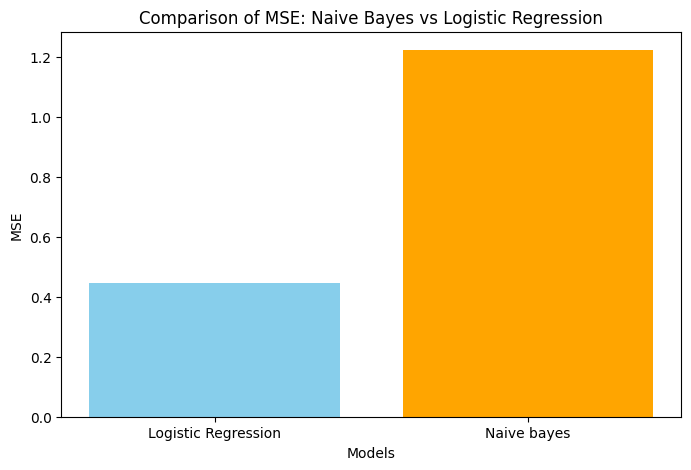

In [36]:
import matplotlib.pyplot as plt
mse_values = [mse_reduced, mse_augmented]

# Model names and MSEs
models = ['Logistic Regression', 'Naive bayes']


# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['skyblue', 'orange'])
plt.title('Comparison of MSE: Naive Bayes vs Logistic Regression')
plt.xlabel('Models')
plt.ylabel('MSE')

# Show the plot
plt.show()